In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Bidirectional, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2023-04-01 19:06:59.073806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data = pd.read_csv('/Users/inigoparra/Desktop/GitHub Repositories/Eu2Vec-Models/master.csv')
print(len(data))

import pandas as pd
import numpy as np
from collections import Counter

def count_unique_tokens(data, columns=None):

    if columns is None:
        columns = data.columns

    text_data = data[columns].apply(lambda x: ' '.join(x.astype(str)), axis=1)
    tokens = text_data.str.split().explode()
    unique_tokens = len(np.unique(tokens))

    return unique_tokens


unique_tokens_count = count_unique_tokens(data)
print(f'The number of unique tokens in the DataFrame is: {unique_tokens_count}')


9990
The number of unique tokens in the DataFrame is: 15562


In [4]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

X_train = train_data['text']
y_train = train_data['label']
X_test = test_data['text']
y_test = test_data['label']
X_val = val_data['text']
y_val = val_data['label']

In [5]:
with open('/Users/inigoparra/Desktop/GitHub Repositories/WiBaSets/stopwords.txt', 'r') as f:
    stopwords = set(f.read().splitlines())

def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
        
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    return ' '.join(filtered_tokens)

X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)

In [6]:
import re
import nltk

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text) 
    text = re.sub(r'<.*?>', '', text) 
    text = re.sub(r'[0-9]', '', text) 
    text = re.sub(r'[^\w\s]', '', text)  
    text = text.split() 
    text = ' '.join(text)
    return text

X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)
X_val = X_val.apply(clean_text)

print(X_train[1])

iraila bozkatu izango herri gisa gizarte gisa aurrera egitea


In [7]:
max_features = 15600
max_len = 100
embedding_dim = 300

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

In [35]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=max_len))
model.add(Bidirectional(GRU(32, return_sequences=True,
               kernel_regularizer=regularizers.l2(0.02), 
               recurrent_regularizer=regularizers.l2(0.02))))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [36]:
batch_size = 32
epochs = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/100
225/225 [==============================] - 21s 76ms/step - loss: 6.6669 - accuracy: 0.3494 - val_loss: 5.3448 - val_accuracy: 0.3635
Epoch 2/100
225/225 [==============================] - 16s 71ms/step - loss: 4.4028 - accuracy: 0.3938 - val_loss: 3.5968 - val_accuracy: 0.4269
Epoch 3/100
225/225 [==============================] - 16s 72ms/step - loss: 3.0215 - accuracy: 0.4633 - val_loss: 2.5376 - val_accuracy: 0.3824
Epoch 4/100
225/225 [==============================] - 16s 72ms/step - loss: 2.1876 - accuracy: 0.4887 - val_loss: 1.9020 - val_accuracy: 0.4747
Epoch 5/100
225/225 [==============================] - 16s 72ms/step - loss: 1.6612 - accuracy: 0.5445 - val_loss: 1.5098 - val_accuracy: 0.4903
Epoch 6/100
225/225 [==============================] - 16s 72ms/step - loss: 1.2961 - accuracy: 0.6207 - val_loss: 1.2864 - val_accuracy: 0.5170
Epoch 7/100
225/225 [==============================] - 16s 72ms/step - loss: 1.0183 - accuracy: 0.7108 - val_loss: 1.1729 - val_ac

In [37]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

32/32 [==============================] - 0s 14ms/step - loss: 1.1173 - accuracy: 0.5776
Test loss: 1.117285966873169, Test accuracy: 0.5775775909423828


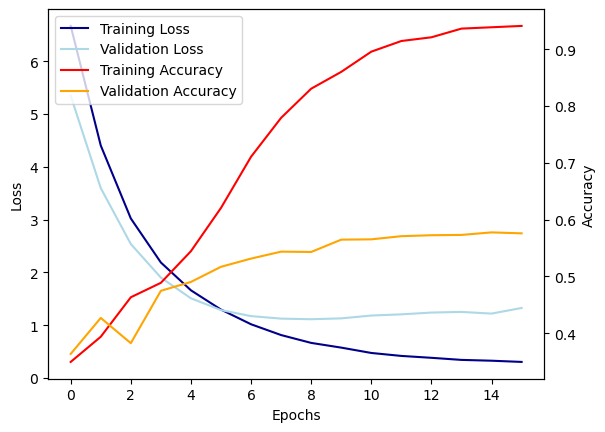

In [38]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(train_loss, label='Training Loss', color='darkblue')
plt.plot(val_loss, label='Validation Loss', color='lightblue')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.twinx()  # Create a second y-axis that shares the same x-axis
plt.plot(train_acc, label='Training Accuracy', color='red')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.ylabel('Accuracy')

handles, labels = [], []
for ax in plt.gcf().axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
plt.legend(handles, labels)

plt.show()

57/57 [==============================] - 2s 14ms/step


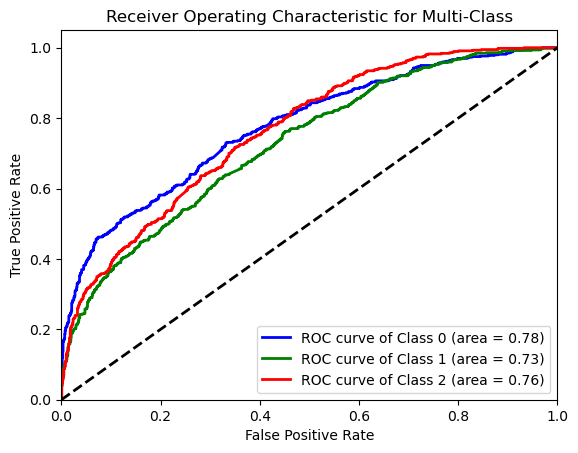

In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_train_onehot = label_binarize(y_train, classes=[0, 1, 2])
y_val_onehot = label_binarize(y_val, classes=[0, 1, 2])
y_pred_proba = model.predict(X_val_pad)
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_onehot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'green', 'red']
class_labels = ['Class 0', 'Class 1', 'Class 2']
lw = 2

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

